<a href="https://colab.research.google.com/github/aricahyasaputra/data-sains-course-assigment-/blob/main/Tubes/gold_price_prediction_with_pca_and_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Gold Prices with PCA and Linear Regression
![gold-bar-4-different-sizes-pbr-3d-model-fbx-ma-blend.jpg](attachment:6ef5a7d9-8b04-45aa-8d13-902d522e5a23.jpg) 

This notebook creates and improves a linear regression model using gold and stock index prices from 2012 until 2019 --[https://www.kaggle.com/sid321axn/gold-price-prediction-dataset](http://) . The data has 81 features. The index consists of individual days. The target feature is "adjusted close". We are trying to predict what the closing price of gold will be given predictors of the gold market itself as well as other stock market indexes. The regular "Close" feature is also removed during model construction. That leaves 78 features to predict the adjusted close price of gold.

I started out building a simple linear regression model with predictors I imagined would be good to start with: the daily high, daily low, daily open, and volume being traded. From there, I created a gradient boosting model and compared its performance with the linear regression model. In this case, the linear regression model had a better mean absolute error than gradient boosting, even when put through a 10-fold cross validation.

Then, I went into feature engineering for a more detailed look of the data. I put 78 features through mutual information analysis. All of the predictors I used for the earlier linear regression and gradient boosting models were the highest performers, with the exception of volume. Next, I created a custom feature that measured daily volatility of gold prices. I compared this with the adjusted close price over time. What I found is that daily volatility was slightly correlated with adjusted close price.

Finally, I continue feature engineering by using PCA to take the top six features with the highest mutual information to adjusted close and created six principal components. I used those six principal components in a new linear regression pipeline. This final model was the best performing of this notebook. See the bottom for the final results.

Thanks to *Manu Siddhartha* for the dataset! Check out his profile here. [https://www.kaggle.com/sid321axn](http://)

All feedback is welcome!

In [3]:
# Import packages
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

In [4]:
# Read the data with pandas and store it in a dataframe titled gold data
df = pd.read_csv('https://raw.githubusercontent.com/aricahyasaputra/data-sains-course-assigment-/main/Tubes/FINAL_USO.csv')

y = df['Adj Close'] 

# We will start out by selecting features gold ETF features
gold_features = ['Open','High', 'Low', 'Volume']
X = df[gold_features]
X.head()

,Open,High,Low,Volume
0,154.740005,154.949997,151.710007,21521900
1,154.309998,155.369995,153.899994,18124300
2,155.479996,155.860001,154.360001,12547200
3,156.820007,157.429993,156.580002,9136300
4,156.979996,157.529999,156.130005,11996100


# Check to see if we have any missing values that we need to impute or remove.

In [5]:
# There are no null values
df.isnull().values.any()

False

# Create Linear Regression Model

In [6]:
# Define Model
gold_model = LinearRegression()

#Fit Model
gold_model.fit(X, y)

print("Making predicitons for the first 5 entries\n")
print(X.head())
print("\nThe predictions are:\n")
print(gold_model.predict(X.head()))
print("\nThe actual values are:\n")
print(y.head())


Making predicitons for the first 5 entries

         Open        High         Low    Volume
0  154.740005  154.949997  151.710007  21521900
1  154.309998  155.369995  153.899994  18124300
2  155.479996  155.860001  154.360001  12547200
3  156.820007  157.429993  156.580002   9136300
4  156.979996  157.529999  156.130005  11996100

The predictions are:

[152.55743325 154.81709905 154.92457233 157.14066214 156.77663033]

The actual values are:

0    152.330002
1    155.229996
2    154.869995
3    156.979996
4    157.160004
Name: Adj Close, dtype: float64


Just based on the first five predictions. We can see that gold_model fitted to the whole data set is able to predict the adjusted close value within a dollar. We will run the whole model through validation and get its mean absolute error.

# Model Validation

In [7]:
predicted_adj_close = gold_model.predict(X.head())
print(mean_absolute_error(y.head(),predicted_adj_close))

predicted_adj_close = gold_model.predict(X)
print(mean_absolute_error(y, predicted_adj_close))

0.2477890674518619
0.21905793913855734


# Partitioning Data
Since we did not split up our data into train, test, and validation sets, the above model could be overfitted.

In [8]:
# Partition data into training and validation groups
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
# Define a new model for training set
gold_model = LinearRegression()
# Fit model
gold_model.fit(train_X, train_y)

#get predicted prices on validation data
val_predictions = gold_model.predict(val_X)
print(mean_absolute_error(val_y,val_predictions))



0.22434694336395747


# Creating a Data Pipeline

MAE: 0.22434694336395747


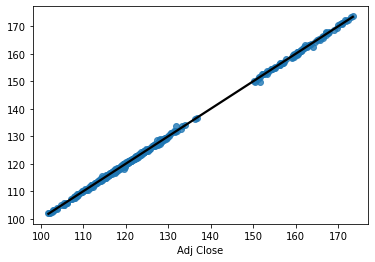

In [9]:
gold_model = LinearRegression()

# Bundle preporcessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('gold_model', gold_model)])
# Preprocessing of training data, fit model
my_pipeline.fit(train_X, train_y)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(val_X)

# Evaluate the model
mae_score = mean_absolute_error(val_y, preds)
print('MAE:', mae_score)

# Display Model
sns.regplot(x=val_y, y=preds, line_kws={"color":"black"})


# Run Model through Cross-Validation

In [10]:
# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=10,
                              scoring = 'neg_mean_absolute_error')
print("MAE scores:\n",scores,"\n")
print("Average MAE score (across all ten folds):")
print(scores.mean())

rmse = math.sqrt(mean_squared_error(val_y,preds))
print("\nRMSE is",rmse)

r2 = r2_score(val_y, preds)
print("\nr2 score is", r2)

MAE scores:
 [0.33869539 0.28749731 0.27608857 0.18376062 0.19862309 0.20854433
 0.23916281 0.16176519 0.17072235 0.14091063] 

Average MAE score (across all ten folds):
0.22057702723053926

RMSE is 0.3257335889369903

r2 score is 0.9996725196712021


# Create a Gradient Boosting Model

In [11]:
my_model = XGBRegressor()
my_model.fit(train_X, train_y)

# Make predictions using XGBoost model
predictions = my_model.predict(val_X)
print("Mean Absolute Error: ",mean_absolute_error(predictions, val_y))

[16:19:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error:  0.37965858894894583


This is much worse than our linear regression model. We will need to adjust some of our parameters to make sure we get the best result XGBoost can afford us. We will start by changing: 
1. The number of estimators - the number of times it will go through the modeling cycle.
2. The early stopping round - the parameter we set to stop the model when our validation score stops improving.
3. Learning rate - the parameter that means each model will help us less. The lower we set the learning rate, generally, the more accurate our predictions will be.
4. n_jobs - we would change this to build our models faster. Ideally, you match this to the number of cores on your machine to shorten the amount of time the model is being fit.

[16:19:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error 0.32533198773619154

RMSE is 0.48743736970953394

r2 score is 0.9992666728364622


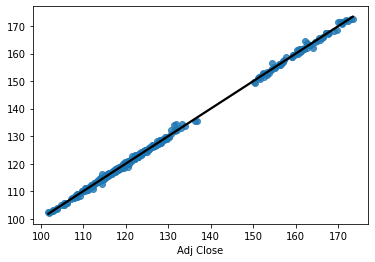

In [12]:
my_model = XGBRegressor(n_estimators=1000,
                        learning_rate=0.03,
                        n_jobs=4)
my_model.fit(train_X, train_y,
            early_stopping_rounds=5,
            eval_set=[(val_X, val_y)],
            verbose=False)

predictions = my_model.predict(val_X)
print("Mean Absolute Error",
      mean_absolute_error(predictions,val_y))

rmse = math.sqrt(mean_squared_error(val_y,predictions))
print("\nRMSE is", rmse)

r2 = r2_score(val_y,predictions)
print("\nr2 score is", r2)

sns.regplot(x=val_y, y=predictions, line_kws={"color": "black"})


In this instance, XGBoost has a MAE of 0.325 and an RMSE of 0.490. The linear regression model gave an average MAE of 0.221 after it was run through ten folds of cross validation and an RMSE of 0.326. The linear regression model is slightly superior to XGBoost when given these parameters and validation techniques.

# Feature Engineering
We've built a model that can predict gold's daily adjusted close value with good accuracy. However, this dataset came with 79 predictor features. Obviously, the predictors I just used are most closely related to the adjusted close value. Now we will use feature engineering to determine what are highly correlated features and see if we can build a better model with them. We'll start by ranking features with **mutual information** and show which features rank the highest with seaborn.

In [13]:
# Refresh on what all of the features look like
# There are 79 predictor columns. I am not including Adj Close and Close of the 81 total.

plt.style.use("seaborn-whitegrid")

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


In [14]:
# Create new ds with all predictor features. Take Adj Close as Y
# Remove Close because it is too close to Adj Close
X = df.copy()
y = X.pop('Adj Close')
date = X.pop('Date')
X.pop('Close')

0       152.330002
1       155.229996
2       154.869995
3       156.979996
4       157.160004
           ...    
1713    120.019997
1714    119.660004
1715    120.570000
1716    121.059998
1717    121.250000
Name: Close, Length: 1718, dtype: float64

In [15]:
# Create mutual info scores

def make_mi_scores (X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)

Construct a bar plot to show each feature's score.

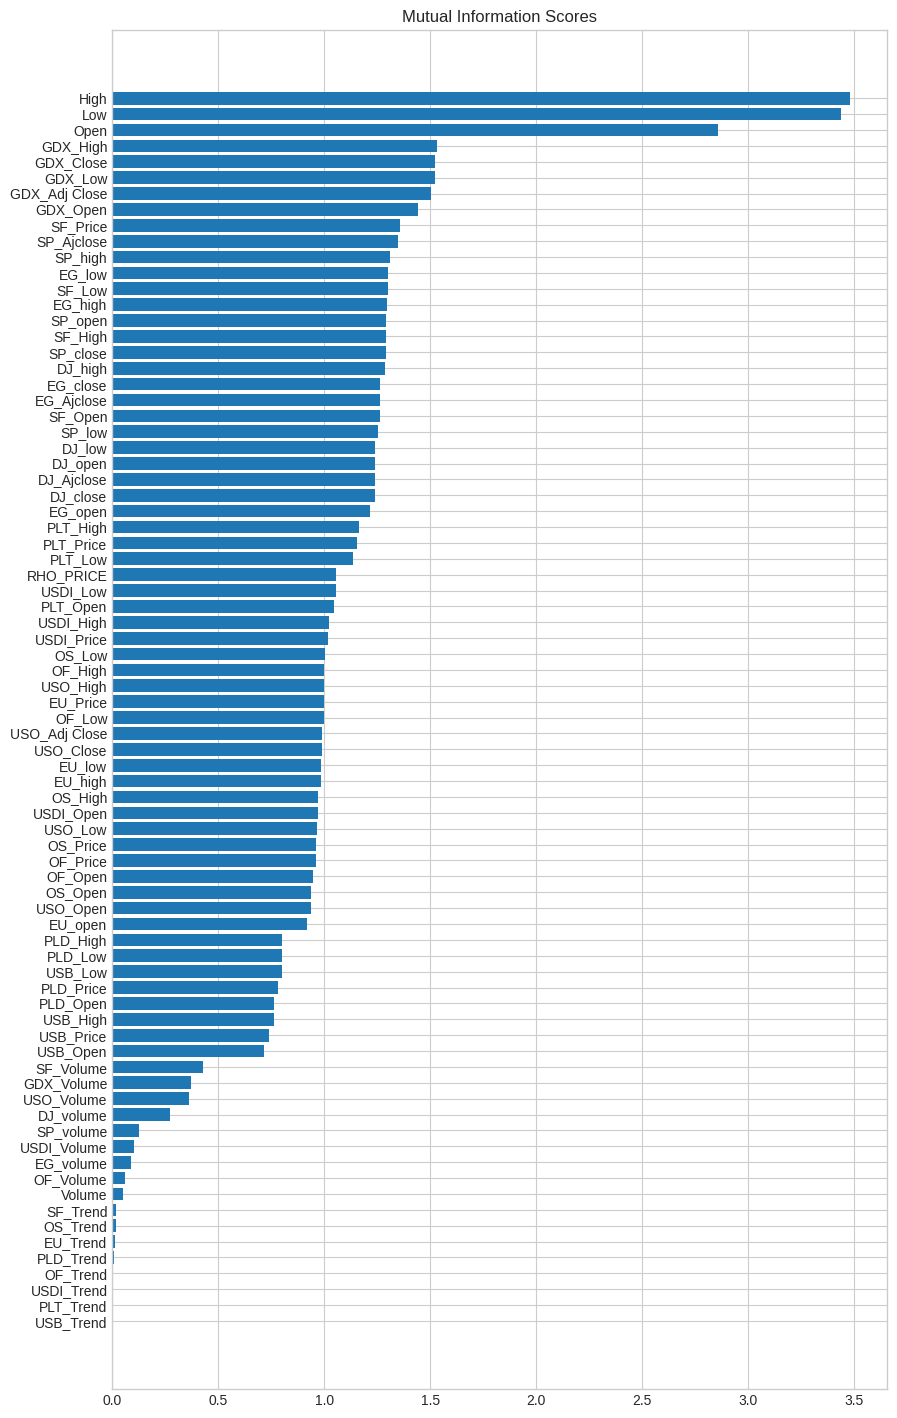

In [16]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
plt.figure(dpi=100, figsize=(10,18))
plot_mi_scores(mi_scores)
    

No wonder our earlier models performed so well. We were already using the best predictors: High, Low, and Open. The predictor we used that has very low mutual information is Volume. In fact, Volume has a lower mutual information than other volumes for stock market indicies. Thanks to the graph above, we know to drop Volume as a predictor and perhaps add in higher ranking predictors such as GDX_High and GDX_Close. It seems that the volume and trend categories of predictors always have a lower MI score than any high, low, or open predictor.

High, Low and Open are extremely correlated to the Adj Close value. Let's create simple regplots to magnify their relationships. You will see that as their mutual information rank gets lower, the less correlated that feature's regplot is with adjusted close.

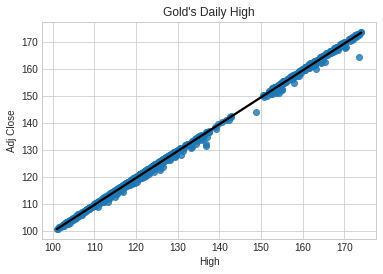

In [17]:
daily_high = sns.regplot(x="High", y="Adj Close", data=df, line_kws={"color": "black"}).set(title="Gold's Daily High")


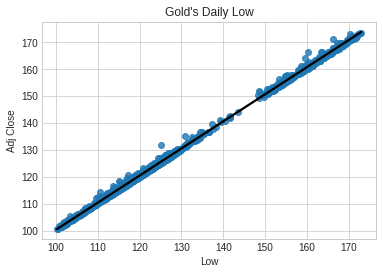

In [18]:
daily_low = sns.regplot(x="Low", y="Adj Close", data=df, line_kws={"color": "black"}).set(title="Gold's Daily Low")


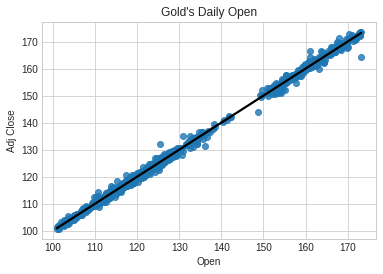

In [19]:
daily_close = sns.regplot(x="Open", y="Adj Close", data=df, line_kws={"color": "black"}).set(title="Gold's Daily Open")

We can see that these three native features are very good predictors for the adjusted close price. However, what if we can create a new feature that can lend a little more insight into the price of gold. In the code below, we will create a feature called "daily change" by taking the price difference from open and close. Daily change is useless as a predictor on its own, but maybe we can apply it to time-series data to see any trends. Daily change is a way to track the volatility of gold prices.

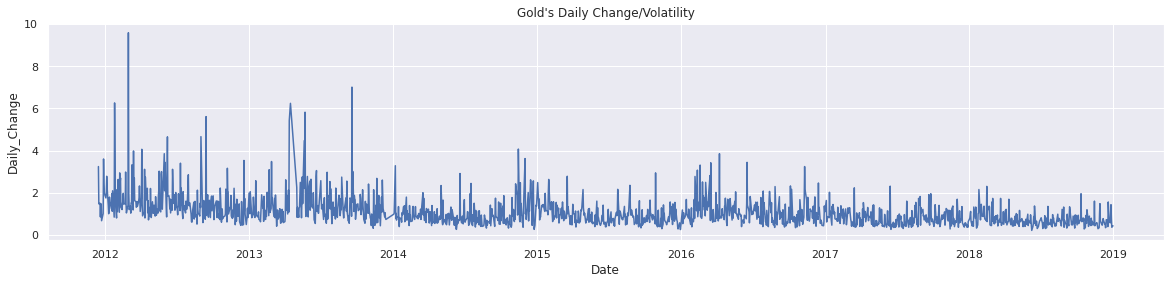

In [20]:
df["Daily_Change"] = abs(X.High - X.Low)

# Convert Date from string to datetime to give us yearly ticks on the X-axis
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

# Plot volatility
sns.set(rc={"figure.figsize":(20, 4)})
daily_change = sns.lineplot(x="Date", y="Daily_Change", data=df).set(title="Gold's Daily Change/Volatility")

We can see that gold prices have gotten less volatile since 2012. Around after mid-2017, gold seems to have become less volatile to the end of 2018. If we were to split up the data from 2012-2013 and 2017-2018 and run them through our linear regression model, we would get better performance from the 2017-2018 dataset because the prices have less daily variation than the 2012-2013 subset. The main takeaway here is that gold volatility has decreased overtime. However, the Adjusted Close has also gone down, as visualized below.

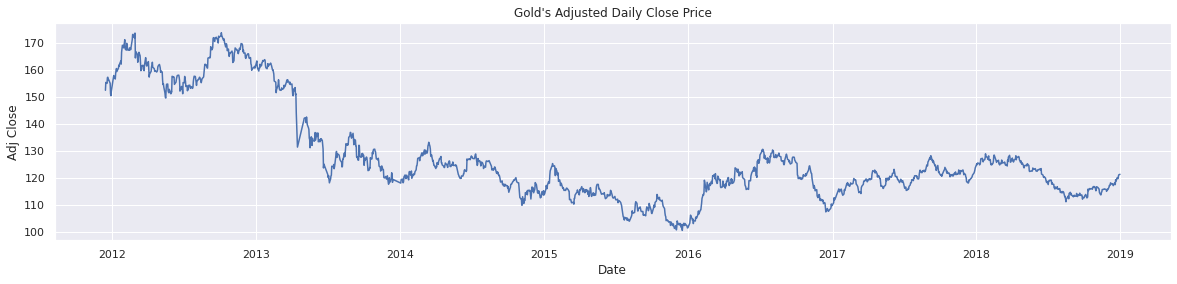

In [21]:
# Adjusted Close with Time Series
sns.set(rc={"figure.figsize":(20, 4)})
daily_change = sns.lineplot(x="Date", y="Adj Close", data=df).set(title="Gold's Adjusted Daily Close Price")

Next we'll apply principal component analysis (PCA). PCA will be good to use with this dataset for two reasons. 
* The first is that PCA works well with numeric features. All of our features, with the exception of Date, are numeric features.
* Many of our features are redundant and are closely related mutual information scores. A lot of them can be removed or combined to create principal components.
We already know that High, Low, and Open have the highest mutual information scores. We also know that those features alone produce a high-performing linear regression model. To experiment with something new. We will leave in the top six features, which means including the gold index(GDX) features.

In [22]:
features = ["High", "Low", "Open", "GDX_High", "GDX_Low", "GDX_Close"]

X = df.copy()
y = X.pop('Adj Close')
date = X.pop('Date')
X.pop('Close')
X = X.loc[:, features]

# Standardize the new df. PCA is sensitive to scale.
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [23]:
# Create principal componenets
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range (X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,4.786447,1.084283,0.062709,0.089771,0.020374,-0.008956
1,4.895857,1.091385,-0.013283,-0.007822,-0.004370,-0.009334
2,4.823785,0.920197,0.005722,0.050612,-0.030129,-0.008412
3,5.092355,0.949527,-0.042882,-0.010260,0.000476,0.002431
4,5.095494,0.961803,-0.020048,0.008791,0.007451,0.000329


In [24]:
# Wrap the PCA loadings up in a dataframe
loadings = pd.DataFrame(
    pca.components_.T,       # Transpose the matrix of loadings
    columns=component_names, # to turn columns into principal components
    index = X.columns,       # and the rows are original features, so we can identify them
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
High,0.408326,-0.401039,0.529359,-0.274509,0.192727,-0.528883
Low,0.408168,-0.413142,-0.558814,-0.298090,-0.510041,0.037945
Open,0.408236,-0.410488,0.040841,0.563978,0.321422,0.491724
GDX_High,0.408251,0.408309,0.433426,0.271772,-0.632694,0.067782
GDX_Low,0.408318,0.402371,-0.466389,0.320687,0.285792,-0.518978
GDX_Close,0.408190,0.413960,0.021448,-0.583966,0.342671,0.450686


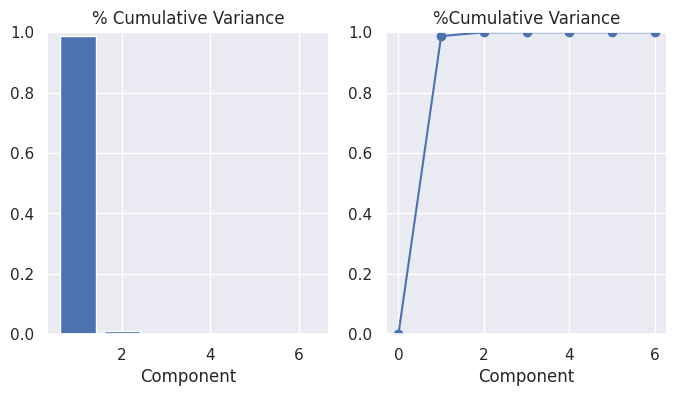

In [25]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1,2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0,cv], "o-")
    axs[1].set(
        xlabel="Component", title="%Cumulative Variance", ylim=(0.0,1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

# Look at the explained variance from PCA
plot_variance(pca);

We can see principal component 1 (PC1) is the most informative by far. A disparity is expected usually between PC1 and the remainders. However, this is a very high disparity. If we didn't look at our features through mutual information earlier. This would raise concern. However, we already know that the first three features are highly correlated with our target feature of adjusted close, so these results make sense.

In [26]:
# View MI Scores for the principal components
mi_scores = make_mi_scores(X_pca, y)
mi_scores

PC1    2.185720
PC2    0.509354
PC3    0.113816
PC5    0.095439
PC4    0.034774
PC6    0.011094
Name: MI Scores, dtype: float64

# New Data Pipeline with PCA
Now that we can see how worthy each principal component is, we can better determine which ones we should add to our new pipeline. In this instance, we will include all prinicpal components in our new pipeline The goal is to beat an MAE of 0.221 after a 10-fold cross validation. 

MAE: 0.20111370689259347


[Text(0.5, 1.0, 'Linear Regression with PCA')]

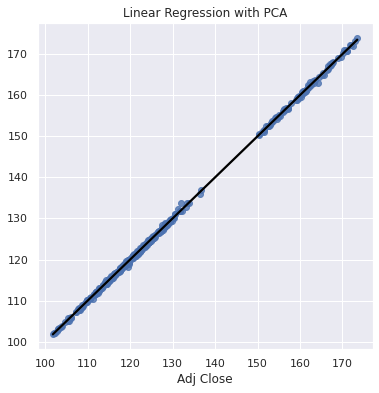

In [27]:
# Partition the PCA dataframe into training and validation groups
train_X, val_X, train_y, val_y = train_test_split(X_pca, y, random_state = 0)

gold_model = LinearRegression()

# Bundle preporcessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('gold_model', gold_model)])
# Preprocessing of training data, fit model
my_pipeline.fit(train_X, train_y)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(val_X)

# Evaluate the model
mae_score = mean_absolute_error(val_y, preds)
print('MAE:', mae_score)

# Display Model
sns.set(rc={"figure.figsize":(6,6)})
sns.regplot(x=val_y, y=preds, line_kws={"color":"black"}).set(title="Linear Regression with PCA")


We can already see PCA helped us improve the model's MAE by 0.20. Let's run the new pipeline through cross-validation to get a more accurate score.

In [28]:
# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X_pca, y,
                              cv=10,
                              scoring = 'neg_mean_absolute_error')
print("MAE scores:\n",scores,"\n")
print("Average MAE score (across all ten folds):")
print(scores.mean())
rmse = math.sqrt(mean_squared_error(val_y,preds))
print("\nRMSE is", rmse)
r2 = r2_score(val_y,preds)
print("\nr2 score is", r2)

MAE scores:
 [0.29200777 0.27589726 0.24365488 0.15945436 0.17239864 0.17891691
 0.19767476 0.13222747 0.15118348 0.12333965] 

Average MAE score (across all ten folds):
0.1926755179335067

RMSE is 0.27542712552287124

r2 score is 0.9997658611136764


#  Three Models Performance Results

In [29]:
results = [['Linear Regression', 0.221, 0.326, 0.999672],
           ['Gradient Boosting (XGBoost)', 0.325, 0.490, 0.999259],
           ['Linear Regression with PCA', 0.193, 0.275, 0.999766]]
results_df = pd.DataFrame(results, columns = ['Model Type', 'MAE', 'RMSE', 'r2'])
results_df

,Model Type,MAE,RMSE,r2
0,Linear Regression,0.221,0.326,0.999672
1,Gradient Boosting (XGBoost),0.325,0.490,0.999259
2,Linear Regression with PCA,0.193,0.275,0.999766


**Good news!** Running the PCA model through ten-fold cross validation gave us our best model performance across all metrics. The simple linear regression model came in second on all metrics as well. XGBoost came in last this time. Although there is slight variation in performance, all three of these models perform well because the top three features are so highly correlated with adjusted time. The dataset has many features, but it would not improve the model significantly by adding ones beyond the top six to a regression model.

Thanks for your time! 

All feedback is welcome!